In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

#dataframe of reviews
df_rottentomatoes = pd.read_csv("C:/Users/aliemir/Desktop/yes/rotten-tomatoes-cleaned.csv")

#dataframe of informations about movies
df_moviesdb = pd.read_csv("C:/Users/aliemir/Desktop/yes/new-movies-database-cleaned.csv")

In [50]:
#Standardization of columns which will be used on merge:
df_rottentomatoes['Movie'] = df_rottentomatoes['Movie'].str.lower()
df_moviesdb['title'] = df_moviesdb['title'].str.lower()

In [51]:
#Merging dataframes:
df_merged = pd.merge(left=df_rottentomatoes, right=df_moviesdb, left_on='Movie', right_on='title')

#Changing types of columns with date:
df_merged['Date'] = pd.to_datetime(df_merged['Date'])
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'])

In [52]:
#Checking columns:
df_merged.columns

Index(['Movie', 'Reviewer', 'Publish', 'Review', 'Date', 'Score', 'Unnamed: 0.1', 'Unnamed: 0', 'Adult', 'backdrop_path', 'genre_ids', 'id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'release_date', 'title', 'video', 'vote_average', 'vote_count', 'studios', 'budget', 'revenue', 'imdb_id', 'Budget', 'gross'], dtype='object')

In [53]:
#Dropping unnecessary columns
unnecessary_columns = ['Unnamed: 0.1', 'Unnamed: 0', 'Adult', 'backdrop_path','original_language', 'original_title', 'poster_path', 'video', 'vote_average', 'vote_count', 'Budget']
df_merged.drop(df_merged[unnecessary_columns], axis=1, inplace=True)

In [54]:
#Function for checking dataframe
def check_df(dataframe, head = 5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0.05, 0.50, 0.95, 1]).T)

In [55]:
#Dropping reviews with rates more than 100
indexes_of_spoiled_data = df_merged[df_merged['Score'] > 100].index
df_merged = df_merged.drop(indexes_of_spoiled_data)
df_merged.head(5)

,Movie,Reviewer,Publish,Review,Date,Score,genre_ids,id,overview,popularity,release_date,title,studios,budget,revenue,imdb_id,gross
0,hotel transylvania: transformania,James Luxford,City AM,I guess its always been hard for me to see the...,2022-03-03,40.0,"[16, 10751, 14, 35, 12]",585083,"When Van Helsing's mysterious invention, the ""...",1240.251,2022-02-25,hotel transylvania: transformania,"['Columbia Pictures', 'Sony Pictures Animation...",0,0,tt9848626,0
1,hotel transylvania: transformania,Mat Brunet,AniMat's Review (YouTube),Hotel Transylvania: Transformania is a present...,2022-02-15,30.0,"[16, 10751, 14, 35, 12]",585083,"When Van Helsing's mysterious invention, the ""...",1240.251,2022-02-25,hotel transylvania: transformania,"['Columbia Pictures', 'Sony Pictures Animation...",0,0,tt9848626,0
2,hotel transylvania: transformania,Robert Levin,Newsday,The conceit still works well enough to mostly ...,2022-01-29,75.0,"[16, 10751, 14, 35, 12]",585083,"When Van Helsing's mysterious invention, the ""...",1240.251,2022-02-25,hotel transylvania: transformania,"['Columbia Pictures', 'Sony Pictures Animation...",0,0,tt9848626,0
3,hotel transylvania: transformania,Jackie K. Cooper,jackiekcooper.com,"No Adam Sandler this time out, but the animate...",2022-01-28,60.0,"[16, 10751, 14, 35, 12]",585083,"When Van Helsing's mysterious invention, the ""...",1240.251,2022-02-25,hotel transylvania: transformania,"['Columbia Pictures', 'Sony Pictures Animation...",0,0,tt9848626,0
4,hotel transylvania: transformania,Asher Luberto,The Playlist,It's not likely we'll see another one of these...,2022-01-28,74.0,"[16, 10751, 14, 35, 12]",585083,"When Van Helsing's mysterious invention, the ""...",1240.251,2022-02-25,hotel transylvania: transformania,"['Columbia Pictures', 'Sony Pictures Animation...",0,0,tt9848626,0


In [56]:
#Normally list values stored as strings in dataframes. Due to this problem the command line below allows list values to be stored as lists.
df_merged["studios"] = df_merged["studios"].apply(eval)

#The function below turns list values to 1D arrays
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

#The codes below shows the movie numbers of studios:
movies = df_merged.groupby('Movie').first()
studios_of_every_movies = to_1D(movies["studios"])
print(studios_of_every_movies.value_counts())

Universal Pictures         212
Warner Bros. Pictures      200
Columbia Pictures          153
Canal+                     137
Paramount                  137
                          ... 
Film Invaders                1
Autopilot Entertainment      1
Floodland Pictures           1
ADL Film Fest Fund           1
Wee Buns                     1
Length: 9796, dtype: int64


In [57]:
#The codes below shows the review numbers of studios:
studios_of_every_reviews = to_1D(df_merged["studios"])
print(studios_of_every_reviews.value_counts())

Warner Bros. Pictures         25725
Universal Pictures            23829
Columbia Pictures             17276
Paramount                     13379
20th Century Fox              12023
                              ...  
The Representation Project        1
Silverscreen Films                1
Kick Pictures                     1
Field Recordings                  1
Titanus                           1
Length: 9796, dtype: int64


In [58]:
#Function to call reviews of specific studios
def reviews_studio(name_of_studio):
    names_of_studios = [name_of_studio]
    mask = df_merged.studios.apply(lambda x: any(item for item in names_of_studios if item in x))
    return df_merged[mask]

In [59]:
#Function to call review years of specific studios
def reviews_years(studio):
    
    #Creating list for years:
    years = []
    
    #Grouping reviews by their date:
    reviews_grouped_by_year = studio.groupby(pd.Grouper(key='Date', axis=0, freq='Y')).first().dropna(subset=['Reviewer'])
    #Reseting index (because 'Date' column becomes index column of dataframe on previous line):
    reviews_grouped_by_year = reviews_grouped_by_year.reset_index()
    
    #Appending every data from 'Date' column of 'reviews_grouped_by_year' to 'years' list:
    for i in reviews_grouped_by_year.index:
        years.append(reviews_grouped_by_year['Date'][i].year)
        
    return years

In [60]:
#The function below returns score means of studios
def scores_mean_of_years(studio, year):
    
    mean_of_scores = studio[studio.Date.dt.year == year].groupby(studio.Date.dt.year)['Score'].mean()
    if mean_of_scores.empty:
        return(np.nan)
    return(mean_of_scores.values[0])

In [61]:
def take_reviews_and_movies_of_studios(studio):
    return reviews_studio(studio), reviews_studio(studio).sort_values(by='Date', ascending=True).groupby('Movie').first().reset_index()

#Taking reviews and years of studios with high amount of comment 
warner_bros_pic, warner_bros_pic_movies = take_reviews_and_movies_of_studios("Warner Bros. Pictures")
universal_pic, universal_pic_movies = take_reviews_and_movies_of_studios("Universal Pictures")
columbia_pic, columbia_pic_movies = take_reviews_and_movies_of_studios("Columbia Pictures")
marvel_stud, marvel_stud_movies = take_reviews_and_movies_of_studios("Marvel Studios")
dc_ent, dc_ent_movies = take_reviews_and_movies_of_studios("DC Entertainment")
pixar, pixar_movies = take_reviews_and_movies_of_studios("Pixar")

years = list(range(2000, 2023))

In [62]:
#Making lists form scores of movie studios:
scores_of_columbia_pic = []
scores_of_universal_pic = []
scores_of_warner_bros_pic = []
scores_of_marvel_stud = []
scores_of_dc_ent = []
scores_of_pixar = []

for year in years:
    scores_of_warner_bros_pic.append(scores_mean_of_years(warner_bros_pic, year))
    scores_of_universal_pic.append(scores_mean_of_years(universal_pic, year))
    scores_of_columbia_pic.append(scores_mean_of_years(columbia_pic, year))
    scores_of_marvel_stud.append(scores_mean_of_years(marvel_stud, year))
    scores_of_dc_ent.append(scores_mean_of_years(dc_ent, year))
    scores_of_pixar.append(scores_mean_of_years(pixar, year))


#Making a dataframe for studios with high amount of movies:
scores_of_big_studios_df = pd.DataFrame({'Columbia Pictures': scores_of_columbia_pic, 'Universal Pictures': scores_of_universal_pic, 'Warner Bros Pcitures': scores_of_warner_bros_pic, 'Years': years})

scores_of_big_studios_df = scores_of_big_studios_df.set_index('Years')

check_df(scores_of_big_studios_df)

##################### Shape #####################
(23, 3)
##################### Types #####################
Columbia Pictures       float64
Universal Pictures      float64
Warner Bros Pcitures    float64
dtype: object
##################### Head #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pcitures
Years                                                             
2000           34.375000           79.681818             67.500000
2001                 NaN           94.000000             83.166667
2002           52.700000           67.368421             50.500000
2003           41.368421           58.181818             70.565217
2004           33.769231           54.411765             60.454545
##################### Tail #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pcitures
Years                                                             
2018           63.602424           59.530183             65.864856
2019          

In [63]:
#Making dataframes from studios with low-volume but high-budget movies:
scores_of_smaller_studios_df = pd.DataFrame({'Marvel Studios': scores_of_marvel_stud, 'Dc Entertaiment': scores_of_dc_ent, 'Pixar': scores_of_pixar, 'Years': years})

scores_of_smaller_studios_df = scores_of_smaller_studios_df.set_index('Years')
check_df(scores_of_smaller_studios_df)

##################### Shape #####################
(23, 3)
##################### Types #####################
Marvel Studios     float64
Dc Entertaiment    float64
Pixar              float64
dtype: object
##################### Head #####################
       Marvel Studios  Dc Entertaiment      Pixar
Years                                            
2000              NaN              NaN        NaN
2001              NaN              NaN  83.419643
2002              NaN              NaN  87.526316
2003              NaN              NaN  88.406475
2004              NaN              NaN  86.230769
##################### Tail #####################
       Marvel Studios  Dc Entertaiment      Pixar
Years                                            
2018        77.434100        70.212209  79.599207
2019        77.062692        68.360577  83.050515
2020        72.611111        64.823077  78.083678
2021        76.884615        71.056818  76.759441
2022        89.708333        71.250000  86.152174

In [64]:
review_number_of_warner_bros_pic = []
review_number_of_universal_pic = []
review_number_of_columbia_pic = []
review_number_of_marvel_stud = []
review_number_of_dc_ent = []
review_number_of_pixar = []

for year in years:
    review_number_of_warner_bros_pic.append(len(warner_bros_pic[warner_bros_pic.Date.dt.year == year]))
    review_number_of_universal_pic.append(len(universal_pic[universal_pic.Date.dt.year == year]))
    review_number_of_columbia_pic.append(len(columbia_pic[columbia_pic.Date.dt.year == year]))
    review_number_of_marvel_stud.append(len(marvel_stud[marvel_stud.Date.dt.year == year]))
    review_number_of_dc_ent.append(len(dc_ent[dc_ent.Date.dt.year == year]))
    review_number_of_pixar.append(len(pixar[pixar.Date.dt.year == year]))

reviews_nums_of_big_studios_by_year = pd.DataFrame({'Columbia Pictures': review_number_of_columbia_pic, 'Universal Pictures': review_number_of_universal_pic, 'Warner Bros Pcitures': review_number_of_warner_bros_pic, 'Years': years})
reviews_nums_of_big_studios_by_year = reviews_nums_of_big_studios_by_year.set_index('Years')

check_df(reviews_nums_of_big_studios_by_year)

##################### Shape #####################
(23, 3)
##################### Types #####################
Columbia Pictures       int64
Universal Pictures      int64
Warner Bros Pcitures    int64
dtype: object
##################### Head #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pcitures
Years                                                             
2000                   4                  11                    11
2001                   0                   1                     6
2002                  20                  19                    21
2003                  19                  33                    23
2004                  13                  34                    22
##################### Tail #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pcitures
Years                                                             
2018                1279                2496                  2612
2019                

In [65]:
reviews_nums_of_smaller_studios_by_year = pd.DataFrame({'Marvel Studios': review_number_of_marvel_stud, 'DC Entertaiment': review_number_of_dc_ent, 'Pixar': review_number_of_pixar, 'Years': years})
reviews_nums_of_smaller_studios_by_year = reviews_nums_of_smaller_studios_by_year.set_index('Years')

check_df(reviews_nums_of_smaller_studios_by_year)

##################### Shape #####################
(23, 3)
##################### Types #####################
Marvel Studios     int64
DC Entertaiment    int64
Pixar              int64
dtype: object
##################### Head #####################
       Marvel Studios  DC Entertaiment  Pixar
Years                                        
2000                0                0      0
2001                0                0     56
2002                0                0     19
2003                0                0    139
2004                0                0     13
##################### Tail #####################
       Marvel Studios  DC Entertaiment  Pixar
Years                                        
2018              911              172    353
2019             1181              104    388
2020              144               65    484
2021               65               44    284
2022               12                6     23
##################### NA #####################
Marvel Studios

In [66]:
movie_number_of_warner_bros_pic = []
movie_number_of_universal_pic = []
movie_number_of_columbia_pic = []
movie_number_of_marvel_stud = []
movie_number_of_dc_ent = []
movie_number_of_pixar = []


for year in years:
    movie_number_of_warner_bros_pic.append(len(warner_bros_pic_movies[warner_bros_pic_movies.Date.dt.year == year]))
    movie_number_of_universal_pic.append(len(universal_pic_movies[universal_pic_movies.Date.dt.year == year]))
    movie_number_of_columbia_pic.append(len(columbia_pic_movies[columbia_pic_movies.Date.dt.year == year]))
    movie_number_of_marvel_stud.append(len(marvel_stud_movies[marvel_stud_movies.Date.dt.year == year]))
    movie_number_of_dc_ent.append(len(dc_ent_movies[dc_ent_movies.Date.dt.year == year]))
    movie_number_of_pixar.append(len(pixar_movies[pixar_movies.Date.dt.year == year]))
    
movie_num_of_big_studios_by_year = pd.DataFrame({'Columbia Pictures': movie_number_of_columbia_pic, 'Universal Pictures': movie_number_of_universal_pic, 'Warner Bros Pcitures': movie_number_of_warner_bros_pic, 'Years': years})
movie_num_of_big_studios_by_year = movie_num_of_big_studios_by_year.set_index('Years')

check_df(movie_num_of_big_studios_by_year)

##################### Shape #####################
(23, 3)
##################### Types #####################
Columbia Pictures       int64
Universal Pictures      int64
Warner Bros Pcitures    int64
dtype: object
##################### Head #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pcitures
Years                                                             
2000                   4                   4                     4
2001                   0                   0                     1
2002                   3                   2                     2
2003                   5                   2                     4
2004                   1                   2                     1
##################### Tail #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pcitures
Years                                                             
2018                  12                  22                    16
2019                

In [67]:
movie_num_of_smaller_studios_by_year = pd.DataFrame({'Marvel Studios': movie_number_of_marvel_stud, 'DC Entertaiment': movie_number_of_dc_ent, 'Pixar': movie_number_of_pixar, 'Years': years})
movie_num_of_smaller_studios_by_year = movie_num_of_smaller_studios_by_year.set_index('Years')

check_df(movie_num_of_smaller_studios_by_year)

##################### Shape #####################
(23, 3)
##################### Types #####################
Marvel Studios     int64
DC Entertaiment    int64
Pixar              int64
dtype: object
##################### Head #####################
       Marvel Studios  DC Entertaiment  Pixar
Years                                        
2000                0                0      0
2001                0                0      1
2002                0                0      0
2003                0                0      1
2004                0                0      0
##################### Tail #####################
       Marvel Studios  DC Entertaiment  Pixar
Years                                        
2018                4                5      1
2019                2                4      1
2020                0                2      2
2021                0                2      1
2022                0                0      0
##################### NA #####################
Marvel Studios

In [68]:
movie_budget_of_warner_bros_pic = []
movie_budget_of_universal_pic = []
movie_budget_of_columbia_pic = []
movie_budget_of_marvel_stud = []
movie_budget_of_dc_ent = []
movie_budget_of_pixar = []

for year in years:
    movie_budget_of_warner_bros_pic.append(warner_bros_pic_movies[warner_bros_pic_movies.Date.dt.year == year]['budget'].median(numeric_only=False))
    movie_budget_of_universal_pic.append(universal_pic_movies[universal_pic_movies.Date.dt.year == year]['budget'].median(numeric_only=False))
    movie_budget_of_columbia_pic.append(columbia_pic_movies[columbia_pic_movies.Date.dt.year == year]['budget'].median(numeric_only=False))
    movie_budget_of_marvel_stud.append(marvel_stud_movies[marvel_stud_movies.Date.dt.year == year]['budget'].median(numeric_only=False))
    movie_budget_of_dc_ent.append(dc_ent_movies[dc_ent_movies.Date.dt.year == year]['budget'].median(numeric_only=False))    
    movie_budget_of_pixar.append(pixar_movies[pixar_movies.Date.dt.year == year]['budget'].median(numeric_only=False))
    
movie_budgets_of_big_studios_by_year = pd.DataFrame({'Columbia Pictures': movie_budget_of_columbia_pic, 'Universal Pictures': movie_budget_of_universal_pic, 'Warner Bros Pcitures': movie_budget_of_warner_bros_pic, 'Years': years})
movie_budgets_of_big_studios_by_year = movie_budgets_of_big_studios_by_year.set_index('Years')

check_df(movie_budgets_of_big_studios_by_year)

##################### Shape #####################
(23, 3)
##################### Types #####################
Columbia Pictures       float64
Universal Pictures      float64
Warner Bros Pcitures    float64
dtype: object
##################### Head #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pcitures
Years                                                             
2000           1442000.0          12250000.0                   0.0
2001                 NaN                 NaN             9000000.0
2002                 0.0                 0.0             4500000.0
2003                 0.0          11000000.0                   0.0
2004                 0.0           9000000.0             1100000.0
##################### Tail #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pcitures
Years                                                             
2018          41000000.0          14500000.0            33000000.0
2019          

In [69]:
movie_budgets_of_smaller_studios_by_year = pd.DataFrame({'Marvel Studios': movie_budget_of_marvel_stud, 'DC Entertaiment': movie_budget_of_dc_ent, 'Pixar': movie_budget_of_pixar, 'Years': years})
movie_budgets_of_smaller_studios_by_year = movie_budgets_of_smaller_studios_by_year.set_index('Years')

check_df(movie_budgets_of_smaller_studios_by_year)

##################### Shape #####################
(23, 3)
##################### Types #####################
Marvel Studios     float64
DC Entertaiment    float64
Pixar              float64
dtype: object
##################### Head #####################
       Marvel Studios  DC Entertaiment        Pixar
Years                                              
2000              NaN              NaN          NaN
2001              NaN              NaN  115000000.0
2002              NaN              NaN          NaN
2003              NaN              NaN   94000000.0
2004              NaN              NaN          NaN
##################### Tail #####################
       Marvel Studios  DC Entertaiment        Pixar
Years                                              
2018      250000000.0              0.0  200000000.0
2019      156000000.0              0.0  175000000.0
2020              NaN              0.0  175000000.0
2021              NaN              0.0  200000000.0
2022              NaN  

In [70]:
movie_sum_of_budget_of_warner_bros_pic = []
movie_sum_of_budget_of_universal_pic = []
movie_sum_of_budget_of_columbia_pic = []
movie_sum_of_budget_of_marvel_stud = []
movie_sum_of_budget_of_dc_ent = []
movie_sum_of_budget_of_pixar = []

for year in years:
    movie_sum_of_budget_of_warner_bros_pic.append(warner_bros_pic_movies[warner_bros_pic_movies.Date.dt.year == year]['budget'].astype(int).sum())
    movie_sum_of_budget_of_universal_pic.append(universal_pic_movies[universal_pic_movies.Date.dt.year == year]['budget'].astype(int).sum())
    movie_sum_of_budget_of_columbia_pic.append(columbia_pic_movies[columbia_pic_movies.Date.dt.year == year]['budget'].astype(int).sum())
    movie_sum_of_budget_of_marvel_stud.append(marvel_stud_movies[marvel_stud_movies.Date.dt.year == year]['budget'].astype(int).sum())
    movie_sum_of_budget_of_dc_ent.append(dc_ent_movies[dc_ent_movies.Date.dt.year == year]['budget'].astype(int).sum())    
    movie_sum_of_budget_of_pixar.append(pixar_movies[pixar_movies.Date.dt.year == year]['budget'].astype(int).sum())
    
sum_of_budget_of_movie_studios_by_year = pd.DataFrame({'Columbia Pictures': movie_sum_of_budget_of_columbia_pic, 'Universal Pictures': movie_sum_of_budget_of_universal_pic, 'Warner Bros Pcitures': movie_sum_of_budget_of_warner_bros_pic, 'Marvel Studios': movie_sum_of_budget_of_marvel_stud, 'DC Entertaiment': movie_sum_of_budget_of_dc_ent, 'Pixar': movie_sum_of_budget_of_pixar, 'Years': years})
sum_of_budget_of_movie_studios_by_year = sum_of_budget_of_movie_studios_by_year.set_index('Years')

check_df(sum_of_budget_of_movie_studios_by_year)

##################### Shape #####################
(23, 6)
##################### Types #####################
Columbia Pictures       int64
Universal Pictures      int64
Warner Bros Pcitures    int64
Marvel Studios          int64
DC Entertaiment         int64
Pixar                   int64
dtype: object
##################### Head #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pcitures  Marvel Studios  DC Entertaiment      Pixar
Years                                                                                                         
2000            57884000            61500000              40000000               0                0          0
2001                   0                   0               9000000               0                0  115000000
2002            23000000                   0               9000000               0                0          0
2003                   0            22000000              44000000               0            

In [71]:
movie_sum_of_gross_of_warner_bros_pic = []
movie_sum_of_gross_of_universal_pic = []
movie_sum_of_gross_of_columbia_pic = []
movie_sum_of_gross_of_marvel_stud = []
movie_sum_of_gross_of_dc_ent = []
movie_sum_of_gross_of_pixar = []

for year in years:
    movie_sum_of_gross_of_warner_bros_pic.append(warner_bros_pic_movies[warner_bros_pic_movies.Date.dt.year == year]['gross'].sum())
    movie_sum_of_gross_of_universal_pic.append(universal_pic_movies[universal_pic_movies.Date.dt.year == year]['gross'].sum())
    movie_sum_of_gross_of_columbia_pic.append(columbia_pic_movies[columbia_pic_movies.Date.dt.year == year]['gross'].sum())
    movie_sum_of_gross_of_marvel_stud.append(marvel_stud_movies[marvel_stud_movies.Date.dt.year == year]['gross'].sum())
    movie_sum_of_gross_of_dc_ent.append(dc_ent_movies[dc_ent_movies.Date.dt.year == year]['gross'].sum())    
    movie_sum_of_gross_of_pixar.append(pixar_movies[pixar_movies.Date.dt.year == year]['gross'].sum())
    
sum_of_gross_of_movie_studios_by_year = pd.DataFrame({'Columbia Pictures': movie_sum_of_gross_of_columbia_pic, 'Universal Pictures': movie_sum_of_gross_of_universal_pic, 'Warner Bros Pcitures': movie_sum_of_gross_of_warner_bros_pic, 'Marvel Studios': movie_sum_of_gross_of_marvel_stud, 'DC Entertaiment': movie_sum_of_gross_of_dc_ent, 'Pixar': movie_sum_of_gross_of_pixar, 'Years': years})
sum_of_gross_of_movie_studios_by_year = sum_of_gross_of_movie_studios_by_year.set_index('Years')

check_df(sum_of_gross_of_movie_studios_by_year)

##################### Shape #####################
(23, 6)
##################### Types #####################
Columbia Pictures       int64
Universal Pictures      int64
Warner Bros Pcitures    int64
Marvel Studios          int64
DC Entertaiment         int64
Pixar                   int64
dtype: object
##################### Head #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pcitures  Marvel Studios  DC Entertaiment      Pixar
Years                                                                                                         
2000            16258992           102564060              45545674               0                0          0
2001                   0                   0              46236000               0                0  579707738
2002            29821776                   0              11805076               0                0          0
2003            13300000            40982192             368875760               0            

In [72]:
earning_rates_of_columbia_pic = []
earning_rates_of_universal_pic = []
earning_rates_of_warner_bros_pic = []
earning_rates_of_pixar = []
earning_rates_of_marvel_stud = []
earning_rates_of_dc_ent = []

years_2 = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

for year in years_2:
    earning_rates_of_columbia_pic.append(columbia_pic_movies[columbia_pic_movies.Date.dt.year == year]['gross'].sum()/columbia_pic_movies[columbia_pic_movies.Date.dt.year == year]['budget'].astype(int).sum())
    earning_rates_of_universal_pic.append(universal_pic_movies[universal_pic_movies.Date.dt.year == year]['gross'].sum()/universal_pic_movies[universal_pic_movies.Date.dt.year == year]['budget'].astype(int).sum())
    earning_rates_of_warner_bros_pic.append(warner_bros_pic_movies[warner_bros_pic_movies.Date.dt.year == year]['gross'].sum()/warner_bros_pic_movies[warner_bros_pic_movies.Date.dt.year == year]['budget'].astype(int).sum())
    earning_rates_of_pixar.append(pixar_movies[pixar_movies.Date.dt.year == year]['gross'].sum()/pixar_movies[pixar_movies.Date.dt.year == year]['budget'].astype(int).sum())
    earning_rates_of_marvel_stud.append(marvel_stud_movies[marvel_stud_movies.Date.dt.year == year]['gross'].sum()/marvel_stud_movies[marvel_stud_movies.Date.dt.year == year]['budget'].astype(int).sum())
    earning_rates_of_dc_ent.append(dc_ent_movies[dc_ent_movies.Date.dt.year == year]['gross'].sum()/dc_ent_movies[dc_ent_movies.Date.dt.year == year]['budget'].astype(int).sum())

earning_rates_of_movie_studios_by_year = pd.DataFrame({'Columbia Pictures': earning_rates_of_columbia_pic, 'Universal Pictures': earning_rates_of_universal_pic, 'Warner Bros Pictures': earning_rates_of_warner_bros_pic, 'Marvel Studios': earning_rates_of_marvel_stud, 'Pixar': earning_rates_of_pixar, 'Years': years_2})

earning_rates_of_movie_studios_by_year = earning_rates_of_movie_studios_by_year.set_index('Years')

check_df(earning_rates_of_movie_studios_by_year)

##################### Shape #####################
(15, 5)
##################### Types #####################
Columbia Pictures       float64
Universal Pictures      float64
Warner Bros Pictures    float64
Marvel Studios          float64
Pixar                   float64
dtype: object
##################### Head #####################
       Columbia Pictures  Universal Pictures  Warner Bros Pictures  Marvel Studios     Pixar
Years                                                                                       
2008            3.143026            2.472320              2.620749        2.932990       NaN
2009            2.462952            1.934242              3.634526             NaN  4.200566
2010            2.810426            2.232700              3.124868             NaN       NaN
2011            3.051353            2.256949              3.690713        2.995511  2.799262
2012            3.595652            3.030890              2.958442             NaN  2.913423
##################

Text(0, 0.5, 'Movie number')

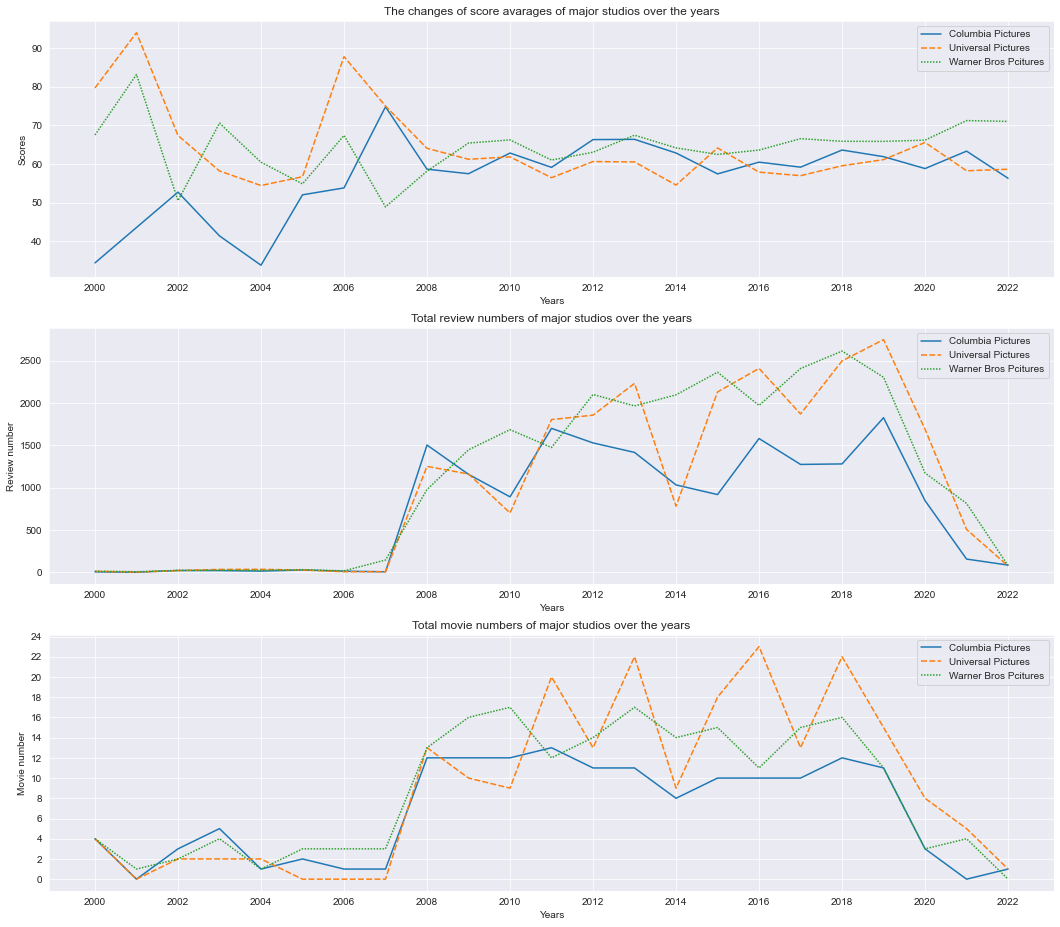

In [39]:
plt.figure(figsize = (18,16))

sns.set_style("darkgrid")
plt.subplot(3,1,1)
plt.title('The changes of score avarages of major studios over the years')
lineplot_of_scores_of_big_studios_df = sns.lineplot(data=scores_of_big_studios_df)
lineplot_of_scores_of_big_studios_df = lineplot_of_scores_of_big_studios_df.set_xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.ylabel('Scores')
 
sns.set_style("darkgrid")
plt.subplot(3,1,2)
plt.title('Total review numbers of major studios over the years')
lineplot_of_reviews_nums_of_big_studios_by_year = sns.lineplot(data=reviews_nums_of_big_studios_by_year)
lineplot_of_reviews_nums_of_big_studios_by_year = lineplot_of_reviews_nums_of_big_studios_by_year.set_xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.ylabel('Review number')

sns.set_style("darkgrid")
plt.subplot(3,1,3)
plt.title('Total movie numbers of major studios over the years')
lineplot_of_movie_nums_of_big_studios_by_year = sns.lineplot(data=movie_num_of_big_studios_by_year)
lineplot_of_movie_nums_of_big_studios_by_year = lineplot_of_movie_nums_of_big_studios_by_year.set_xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.yticks(list(range(0, 26, 2)))
plt.ylabel('Movie number')

Text(0, 0.5, 'Budget')

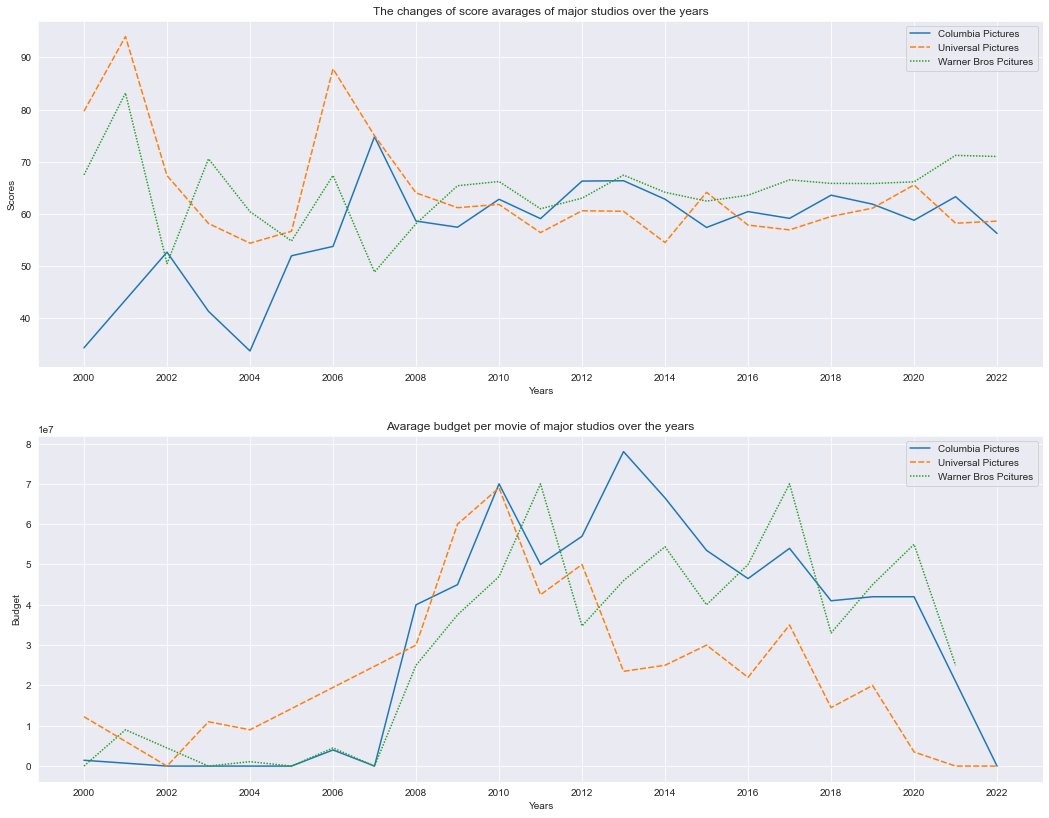

In [40]:
plt.figure(figsize = (18,14))

sns.set_style("darkgrid")
plt.subplot(2,1,1)
plt.title('The changes of score avarages of major studios over the years')
lineplot_of_scores_of_big_studios_df = sns.lineplot(data=scores_of_big_studios_df)
lineplot_of_scores_of_big_studios_df = lineplot_of_scores_of_big_studios_df.set_xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.ylabel('Scores')

sns.set_style("darkgrid")
plt.subplot(2,1,2)
plt.title('Avarage budget per movie of major studios over the years')
lineplot_of_movie_budgets_of_big_studios_by_year = sns.lineplot(data=movie_budgets_of_big_studios_by_year)
lineplot_of_movie_budgets_of_big_studios_by_year = lineplot_of_movie_budgets_of_big_studios_by_year.set_xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.ylabel('Budget')

Text(0, 0.5, 'Movie number')

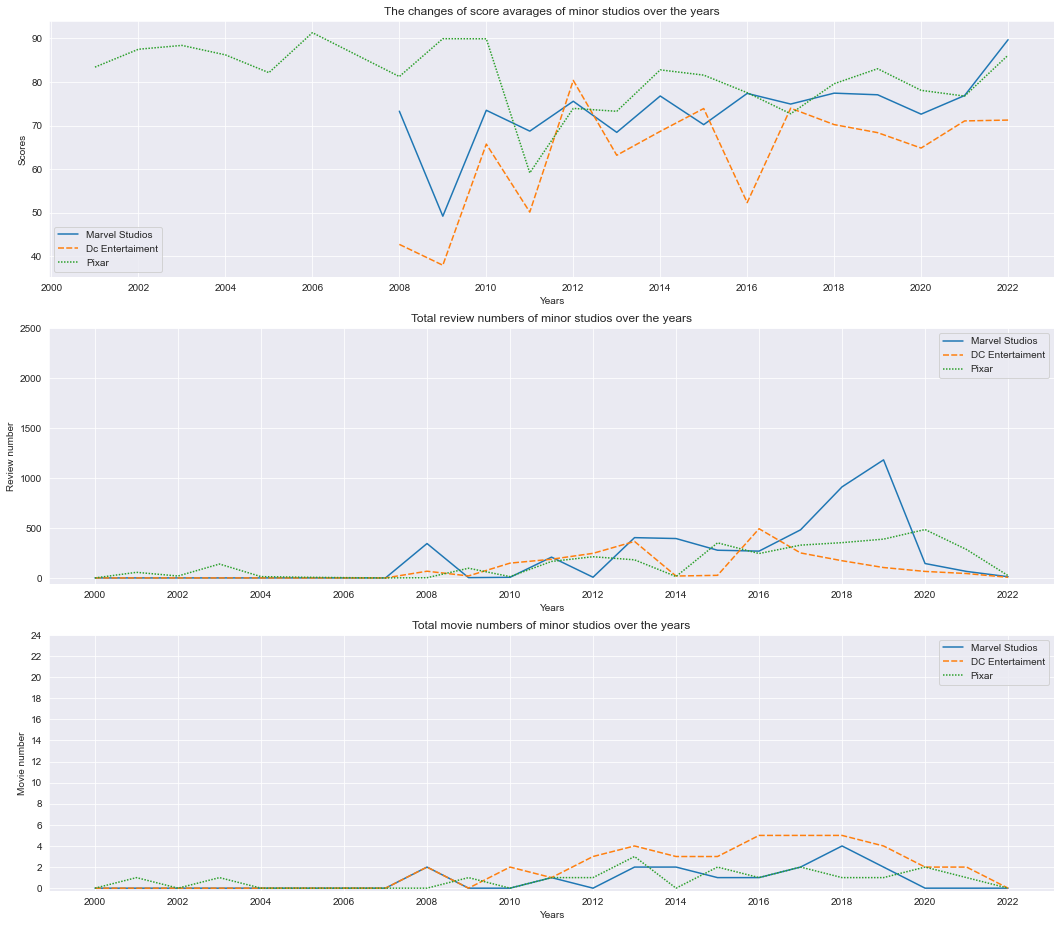

In [41]:
plt.figure(figsize = (18,16))

sns.set_style("darkgrid")
plt.subplot(3,1,1)
plt.title('The changes of score avarages of minor studios over the years')
lineplot_of_scores_of_smaller_studios_df = sns.lineplot(data = scores_of_smaller_studios_df)
lineplot_of_scores_of_smaller_studios_df = lineplot_of_scores_of_smaller_studios_df.set_xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.ylabel('Scores')
 
sns.set_style("darkgrid")
plt.subplot(3,1,2)
plt.title('Total review numbers of minor studios over the years')
lineplot_of_reviews_nums_of_smaller_studios_by_year = sns.lineplot(data=reviews_nums_of_smaller_studios_by_year)
lineplot_of_reviews_nums_of_smaller_studios_by_year = lineplot_of_reviews_nums_of_smaller_studios_by_year.set_xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.yticks(list(range(0, 2501, 500)))
plt.ylabel('Review number')

sns.set_style("darkgrid")
plt.subplot(3,1,3)
plt.title('Total movie numbers of minor studios over the years')
lineplot_of_movie_nums_of_smaller_studios_by_year = sns.lineplot(data=movie_num_of_smaller_studios_by_year)
lineplot_of_movie_nums_of_smaller_studios_by_year = lineplot_of_movie_nums_of_smaller_studios_by_year.set_xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.yticks(list(range(0, 26, 2)))
plt.ylabel('Movie number')

Text(0, 0.5, 'Budget')

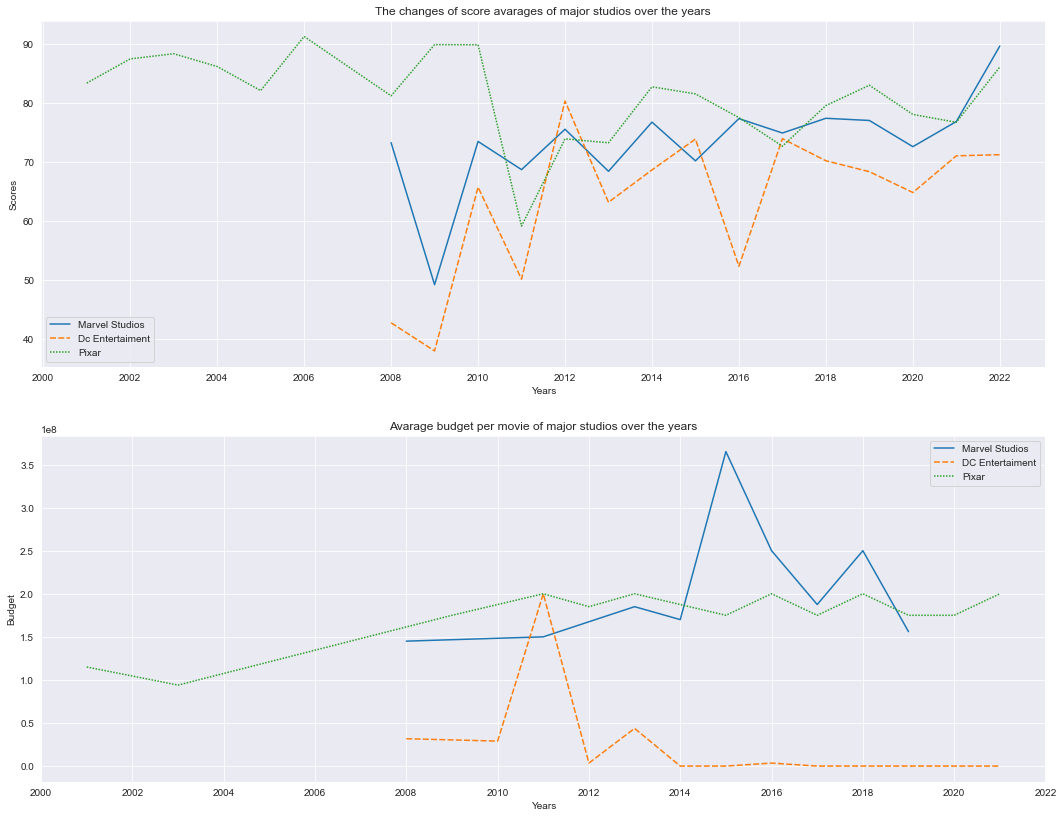

In [43]:
plt.figure(figsize = (18,14))

sns.set_style("darkgrid")
plt.subplot(2,1,1)
plt.title('The changes of score avarages of major studios over the years')
lineplot_of_scores_of_smaller_studios_df = sns.lineplot(data=scores_of_smaller_studios_df)
lineplot_of_scores_of_smaller_studios_df = lineplot_of_scores_of_smaller_studios_df.set_xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.ylabel('Scores')

sns.set_style("darkgrid")
plt.subplot(2,1,2)
plt.title('Avarage budget per movie of major studios over the years')
lineplot_of_movie_budgets_of_smaller_studios_by_year = sns.lineplot(data=movie_budgets_of_smaller_studios_by_year)
lineplot_of_movie_budgets_of_smaller_studios_by_year = lineplot_of_movie_budgets_of_smaller_studios_by_year.set_xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.ylabel('Budget')

Text(0, 0.5, 'Budget')

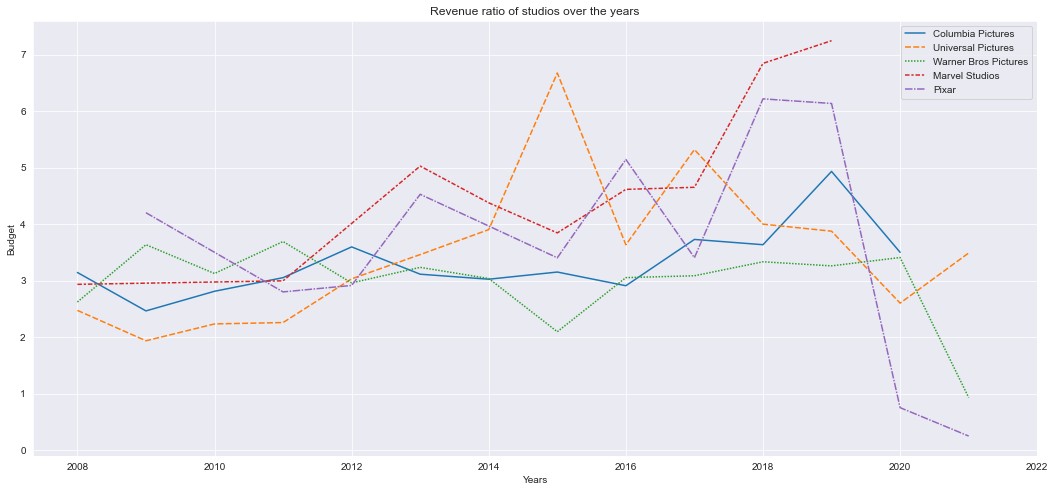

In [44]:
plt.figure(figsize = (18,8))
sns.set_style("darkgrid")
plt.title('Revenue ratio of studios over the years')
lineplot_of_earning_rates_of_movie_studios_by_year = sns.lineplot(data=earning_rates_of_movie_studios_by_year)
lineplot_of_earning_rates_of_movie_studios_by_year = lineplot_of_earning_rates_of_movie_studios_by_year.set_xticks([2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.ylabel('Budget')

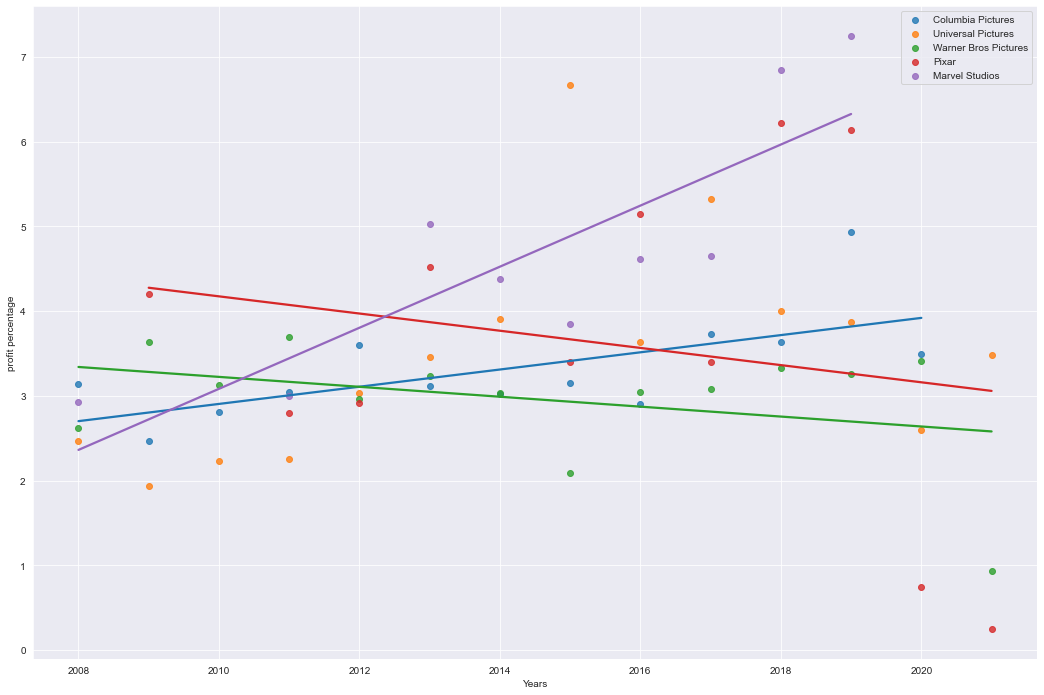

In [45]:
earning_rates_of_columbia_pic_df = pd.DataFrame({'Columbia Pictures': earning_rates_of_columbia_pic, 'Years': years_2})
earning_rates_of_universal_pic_df = pd.DataFrame({'Universal Pictures': earning_rates_of_universal_pic, 'Years': years_2})
earning_rates_of_warner_bros_pic_df = pd.DataFrame({'Warner Bros Pictures': earning_rates_of_warner_bros_pic, 'Years': years_2})
earning_rates_of_pixar_df = pd.DataFrame({'Pixar': earning_rates_of_pixar, 'Years': years_2})
earning_rates_of_marvel_stud_df = pd.DataFrame({'Marvel Studios': earning_rates_of_marvel_stud, 'Years': years_2})
earning_rates_of_dc_ent_df = pd.DataFrame({'DC Entertaiment': earning_rates_of_dc_ent, 'Years': years_2})

# create the figure and axes
fig, ax = plt.subplots(figsize=(18, 12))

# add the plots for each dataframe
sns.regplot(x='Years', y='Columbia Pictures', data=earning_rates_of_columbia_pic_df, fit_reg=True, ci=None, ax=ax, label='Columbia Pictures')
sns.regplot(x='Years', y='Universal Pictures', data=earning_rates_of_universal_pic_df, fit_reg=True, ci=None, ax=ax, label='Universal Pictures')
sns.regplot(x='Years', y='Warner Bros Pictures', data=earning_rates_of_warner_bros_pic_df, fit_reg=True, ci=None, ax=ax, label='Warner Bros Pictures')
sns.regplot(x='Years', y='Pixar', data=earning_rates_of_pixar_df, fit_reg=True, ci=None, ax=ax, label='Pixar')
sns.regplot(x='Years', y='Marvel Studios', data=earning_rates_of_marvel_stud_df, fit_reg=True, ci=None, ax=ax, label='Marvel Studios')

ax.set(ylabel='profit percentage', xlabel='Years')
ax.legend()
plt.show()
